In [1]:
from __future__ import print_function, division

import os
import operator
import functools
import time
import glob
import tables as tb
import pandas as pd
print("Running on ", time.asctime())

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import invisible_cities.database.load_db as DB
import invisible_cities.core.system_of_units_c as SystemOfUnits
import invisible_cities.reco.pmaps_functions as pmapf
import invisible_cities.core.fit_functions as fitf

DataPMT = DB.DataPMT()
DataSiPM = DB.DataSiPM()
units = SystemOfUnits.SystemOfUnits()
pi = np.pi

Running on  Wed May 10 12:23:26 2017


#### General plotting

In [2]:
plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

outputfolder = "plots/Na_Coincidence"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

#### Usefull functions

In [3]:
def width(times, to_mus=False):
    """
    Compute peak width.
    """
    w = (np.max(times) - np.min(times)) if np.any(times) else 0.
    return w * units.ns/units.mus if to_mus else w


def timefunc(f):
    """
    Decorator for function timing.
    """
    def time_f(*args, **kwargs):
        t0 = time.time()
        output = f(*args, **kwargs)
        print("Time spent in {}: {} s".format(f.__name__,
                                              time.time() - t0))
        return output
    return time_f


def integrate_charge(d):
    """
    Integrate charge from a SiPM dictionary.
    """
    newd = dict((key, np.sum(value)) for key, value in d.items())
    return map(np.array, list(zip(*newd.items())))


def flat(nested_list):
    while hasattr(nested_list[0], "__iter__"):
        nested_list = [item for inner_list in nested_list for item in inner_list]
    return np.array(nested_list)


def labels(xlabel, ylabel):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist(*args, **kwargs)

    
def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist2d(*args, **kwargs)

    
def pdf(data, *args, **kwargs):
    """
    Create a normalized histogram with appropiate range.
    """
    data = np.array(data)
    h = hist(data, *args, **kwargs, weights=np.ones_like(data)/len(data))
    plt.yscale("log")
    plt.ylim(1e-4, 1.)
    return h
    
def scatter(*args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    return plt.scatter(*args, **kwargs)


def save_to_folder(outputfolder, name):
    """
    Set title and save plot in folder.
    """
    plt.title(name)
    plt.savefig("{}/{}.png".format(outputfolder, name), dpi=100)



def get_centers(xbins):
    # xbins should be shifted, as it contains the lower bounds
    # and we want bin centers
    return xbins[:-1] + np.diff(xbins) * 0.5


def profile_and_scatter(x, y, z, nbin, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    x, y, z, ze = fitf.profileXY(x, y, z, *nbin, *args, **kwargs)
    x_ = np.repeat(x, x.size)
    y_ = np.tile  (y, y.size)
    z_ = z.flatten()
    return (x, y, z, ze), plt.scatter(x_, y_, c=z_, marker="s"), plt.colorbar()

two_gauss = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:-1])+args[-1]
one_gauss = lambda x, *args: fitf.gauss(x, *args[:3]) +args[-1]
save = functools.partial(save_to_folder, outputfolder)

### Input data

In [11]:
# Comment out this line if your data is in $IC_DATA
os.environ["IC_DATA"] = "/home/brais/Documents/Next/Na/data/"

pattern = "$IC_DATA/37*/dst_*.h5"
ifiles  = glob.glob(os.path.expandvars(pattern))
print("# files:", len(ifiles),"\n",ifiles[5])
print(ifiles)

# files: 19 
 /home/brais/Documents/Next/Na/data/3761/dst_3761.root.h5
['/home/brais/Documents/Next/Na/data/3773/dst_3773.root.h5', '/home/brais/Documents/Next/Na/data/3763/dst_3763.root.h5', '/home/brais/Documents/Next/Na/data/3732/dst_3732.root.h5', '/home/brais/Documents/Next/Na/data/3794/dst_3794.root.h5', '/home/brais/Documents/Next/Na/data/3789/dst_3789.root.h5', '/home/brais/Documents/Next/Na/data/3761/dst_3761.root.h5', '/home/brais/Documents/Next/Na/data/3740/dst_3740.root.h5', '/home/brais/Documents/Next/Na/data/3755/dst_3755.root.h5', '/home/brais/Documents/Next/Na/data/3787/dst_3787.root.h5', '/home/brais/Documents/Next/Na/data/3779/dst_3779.root.h5', '/home/brais/Documents/Next/Na/data/3768/dst_3768.root.h5', '/home/brais/Documents/Next/Na/data/3752/dst_3752.root.h5', '/home/brais/Documents/Next/Na/data/3770/dst_3770.root.h5', '/home/brais/Documents/Next/Na/data/3757/dst_3757.root.h5', '/home/brais/Documents/Next/Na/data/3783/dst_3783.root.h5', '/home/brais/Documents/Next/

### Reading data

In [10]:
def load_dst(filename, group, node):
    with tb.open_file(filename) as h5in:
        table = getattr(getattr(h5in.root, group), node).read()
        return pd.DataFrame.from_records(table)

In [6]:
data_read_3732 = load_dst(ifiles[0], "DST", "Events")
data_read_3740 = load_dst(ifiles[1], "DST", "Events")
data_read_3755 = load_dst(ifiles[2], "DST", "Events")
data_read_3752 = load_dst(ifiles[3], "DST", "Events")
data_read_3723 = load_dst(ifiles[4], "DST", "Events")
data_read_3708 = load_dst(ifiles[5], "DST", "Events")
data_read = [data_read_3708,
            data_read_3723,
            data_read_3732,
            data_read_3740,
            data_read_3752,
            data_read_3755]
data_read_names = ["3708", "3723", "3732", "3740", "3752", "3755"]

In [147]:
for i in range(len(ifiles)): print(sorted(ifiles)[i],len(load_dst(sorted(ifiles)[i], "DST", "Events")))

/home/brais/Documents/Next/Na/data/3708/dst_3708.root.h5 18
/home/brais/Documents/Next/Na/data/3723/dst_3723.root.h5 1076
/home/brais/Documents/Next/Na/data/3732/dst_3732.root.h5 3464
/home/brais/Documents/Next/Na/data/3740/dst_3740.root.h5 13899
/home/brais/Documents/Next/Na/data/3752/dst_3752.root.h5 16682
/home/brais/Documents/Next/Na/data/3755/dst_3755.root.h5 14870
/home/brais/Documents/Next/Na/data/3757/dst_3757.root.h5 17051
/home/brais/Documents/Next/Na/data/3761/dst_3761.root.h5 16570
/home/brais/Documents/Next/Na/data/3763/dst_3763.root.h5 6492
/home/brais/Documents/Next/Na/data/3768/dst_3768.root.h5 9593
/home/brais/Documents/Next/Na/data/3770/dst_3770.root.h5 6688
/home/brais/Documents/Next/Na/data/3773/dst_3773.root.h5 9117
/home/brais/Documents/Next/Na/data/3779/dst_3779.root.h5 3934
/home/brais/Documents/Next/Na/data/3781/dst_3781.root.h5 3131
/home/brais/Documents/Next/Na/data/3783/dst_3783.root.h5 7855
/home/brais/Documents/Next/Na/data/3787/dst_3787.root.h5 6884
/home

### Some plots

In [8]:
data_read_combined = pd.concat(data_read)

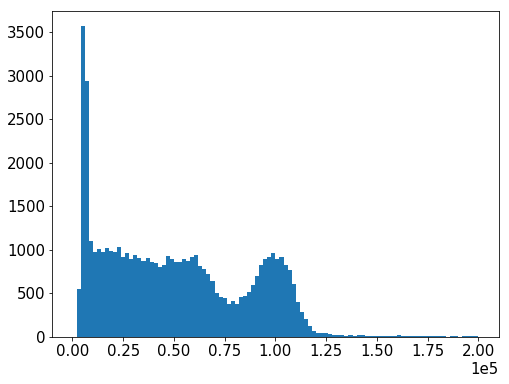

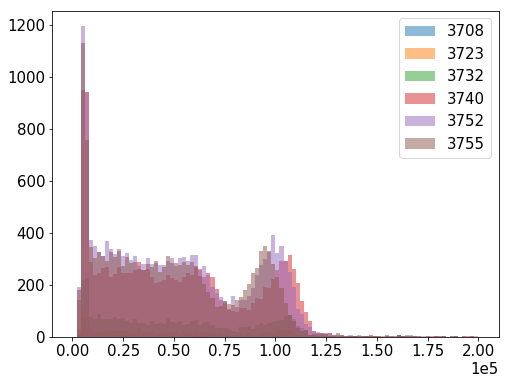

In [9]:
hist(data_read_combined.S2e, 100, [0, 2e5]);
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.figure()
for i in data_read: 
    plt.hist(i.S2e, 100, [0, 2e5], alpha=0.5)
plt.legend(data_read_names)

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

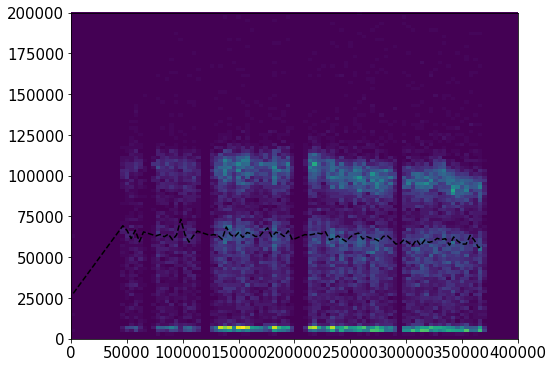

In [10]:
data = data_read_combined[(data_read_combined.Z<210)&(data_read_combined.R<180)]

Et = data.S2e 

time = data.time
time = time-np.min(time)
hist2d(time,Et,[100,100], range=[[0,4e5],[0,2e5]]);
x, y, _ = fitf.profileX(time,Et, 100, yrange=[0,2e5])
plt.plot(x,y,profOpt)

2.9957372390425183

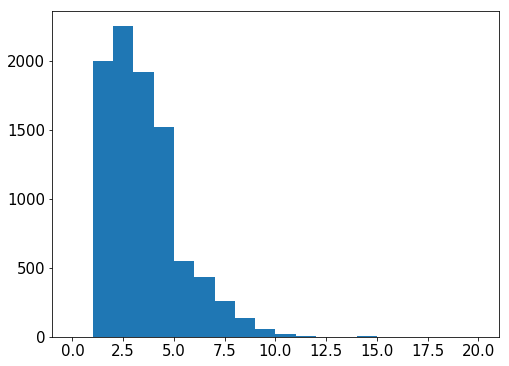

In [11]:
hist(data_read_combined[(data_read_combined.nS2>0)&(data_read_combined.S2e<12e3)].Nsipm, 20, [0,20]);
np.mean(data_read_combined[(data_read_combined.nS2>0)&(data_read_combined.S2e<12e3)].Nsipm)


### XR Filter

In [12]:
from copy import deepcopy
from functools import reduce

def Filter(data):
    filtered_XR = deepcopy(data)
    filtered_noXR = deepcopy(data)
    
    min_S1w = 250.
    max_S1w = 400.
    min_S1h = 10.
    max_S1h = 100.
    
    min_S2e = 2500.
    max_S2e = 10000.
    
    print('Inicial: ',len(filtered_XR), len(filtered_noXR))

    filtered_XR = filtered_XR[filtered_XR.nS2>1]
    print('nS2 > 1: ', len(filtered_XR))
    
    filtered_XR = filtered_XR[filtered_XR.S2e>min_S2e]
    filtered_XR = filtered_XR[filtered_XR.S2e<max_S2e]
    
    
    print('S2 XR Energy: ', len(filtered_XR))
    
    filtered_XR = filtered_XR[filtered_XR.Nsipm>0]
    
    print('Nsimp > 0: ', len(filtered_XR))
    

    
    
    #filtered_noXR = filtered_noXR[filtered_noXR.S2e<min_S2e]
    filtered_noXR = filtered_noXR[filtered_noXR.S2e>max_S2e]
    
    print('no XR: ', len(filtered_noXR))
    
    return filtered_XR, filtered_noXR


In [ ]:
filt_XR, filt_noXR = [], []
for i in data_read:
    XR, noXR = Filter(i)
    filt_XR.append(XR)
    filt_noXR.append(noXR)
#full = data_read[:]

# Corrections per run

## 3740

In [13]:
data_3740 = data_read_3740
filt_XR_3740, filt_noXR_3740 = Filter(data_3740)

Inicial:  13899 13899
nS2 > 1:  7703
S2 XR Energy:  2161
Nsimp > 0:  2161
no XR:  11576


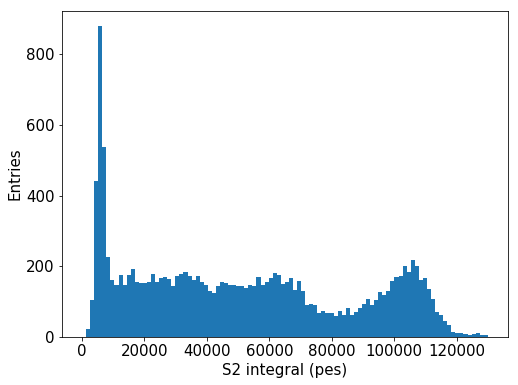

In [14]:
hist(data_3740.S2e,100, [0e3,1.3e5]);
labels("S2 integral (pes)", "Entries")
#save("3740 Raw Energy")

### XR Z correction

FitFunction(fn=<function fit.<locals>.<lambda> at 0x7f59d345b1e0>, values=array([ 8649.39280156,  -494.06661249]), errors=array([ 128.0479757 ,   28.21933712]), chi2=7.0316538360124463)
7808.9942956


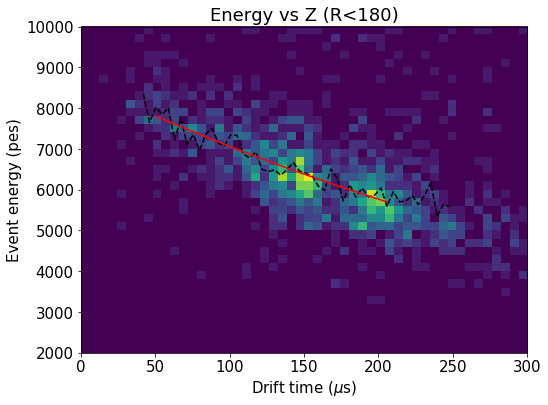

In [17]:
rcut = 180.

data_ = filt_XR_3740[filt_XR_3740.R<rcut]

xbin, ybin, z, axis = hist2d(data_.Z, data_.S2e, [50,40], [[0,300], [2000,10000]])
x, y, _ = fitf.profileX(data_.Z, data_.S2e, 50, xrange=[40,250], yrange=[2000,10000])
plt.plot(x, y, profOpt)
sel  = fitf.in_range(x, 50, 210)
x, y = x[sel], y[sel]
f = fitf.fit(fitf.expo, x, y, (1e5, -250))
plt.plot(x, f.fn(x), fitOpt)
print(f)
labels("Drift time ($\mu$s)", "Event energy (pes)")
save("Energy vs Z (R<180)")

zfun_3740  = f.fn
zmin_3740  = np.min(x)
zcorr_3740 = lambda z: zfun_3740(zmin_3740)/zfun_3740(z)
print(zfun_3740(zmin_3740))

/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:123: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


[  1.01921379e+05   7.70374332e+03   6.12451863e+02   6.82881279e+03
   9.28641455e+03   2.90149260e+02   1.02305564e+00]
res 0.18722380498 0.0206838202681


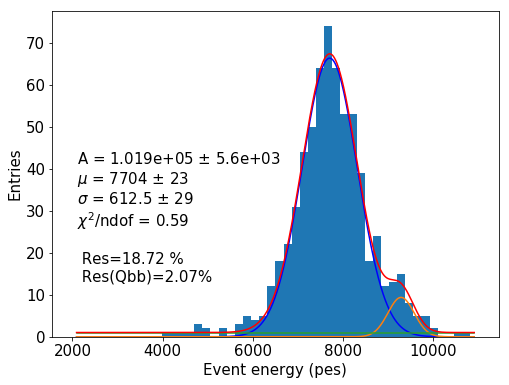

In [23]:
data_ = filt_XR_3740[(filt_XR_3740.R<180)&(filt_XR_3740.Z<150)]
E = data_.S2e * zcorr_3740(data_.Z)

entries, xbins, _ = hist(E, 50, range=(2e3, 11e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 6500, 12000)


f = fitf.fit(two_gauss, xbins[selbins], entries[selbins],( 9e4, 6500, 500, 9e4, 8050, 600, 10),
                                                 bounds=([ 8e4, 6000, 100, 1e3, 8000, 100, 0],
                                                         [ 10e6, 9000, 1000,10e5, 10000, 600, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)

xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]))
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
labels("Event energy (pes)", "Entries")
#save("XR Z Corr (Z<150 R<180)")

### XR xy correction

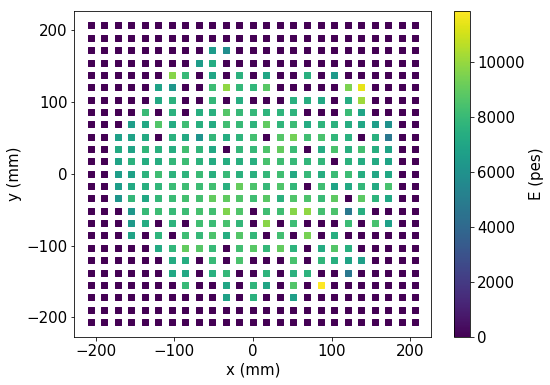

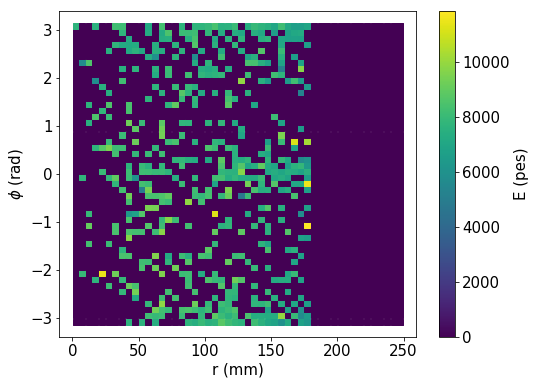

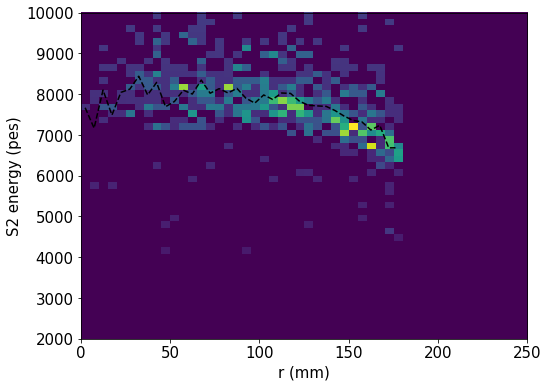

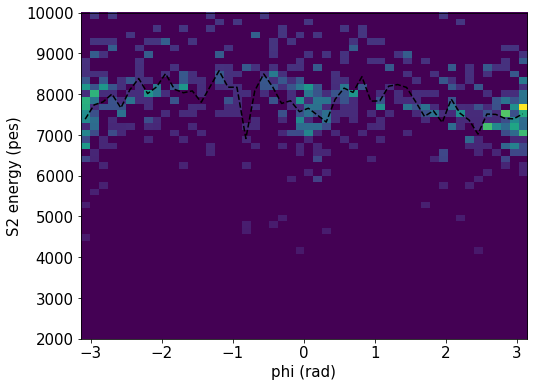

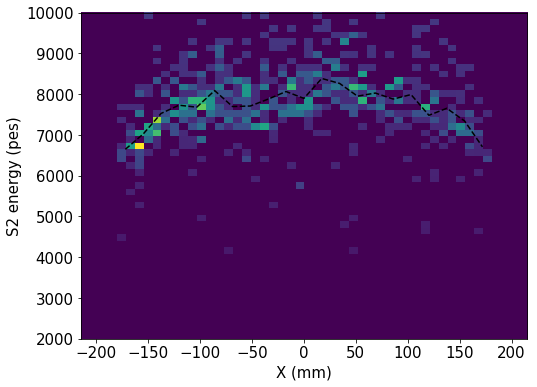

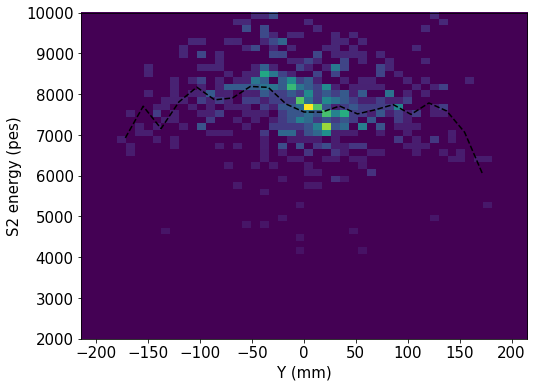

In [24]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 250
prange = - pi,  pi
Erange =  2e3, 10e3
nbin = 50

data_ = filt_XR_3740[(filt_XR_3740.Z<150)&(filt_XR_3740.R<180)][:]
data_ =  data_[data_.S2e * zcorr_3740(data_.Z)<12e3]
Ez  = data_.S2e * zcorr_3740(data_.Z)


pf, _, cb = profile_and_scatter(data_.X, data_.Y, Ez, (25, 25), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
#save("E vs XY")

_, _, cb = profile_and_scatter(data_.R, data_.Phi, Ez, (nbin, nbin), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
#save("E vs RPhi")

hist2d(data_.R, Ez, (nbin, nbin), range=(rrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data_.R, Ez, nbin, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
#save("E vs R")

hist2d(data_.Phi, Ez, (nbin, nbin), range=(prange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data_.Phi, Ez, nbin, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
#save("E vs Phi")

hist2d(data_.X, Ez, (nbin, nbin), range=(xrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data_.X, Ez, 25, xrange=xrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("X (mm)", "S2 energy (pes)")
#save("E vs X")

hist2d(data_.Y, Ez, (nbin, nbin), range=(yrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data_.Y, Ez, 25, xrange=yrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("Y (mm)", "S2 energy (pes)")
#save("E vs Y")



def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
#    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr

xs = np.loadtxt('xycorr_xs_3614.dat')
ys = np.loadtxt('xycorr_ys_3614.dat')
es = np.loadtxt('xycorr_es_3614.dat')

xycorr = get_xycorr(xs, ys,es)

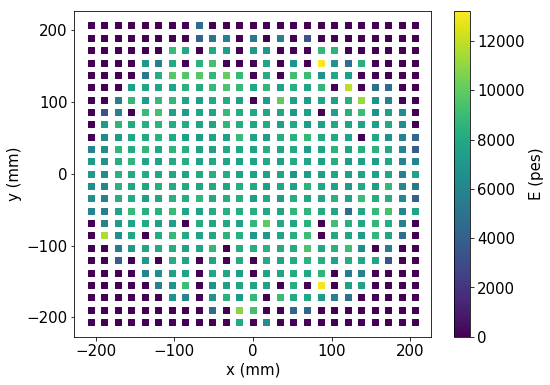

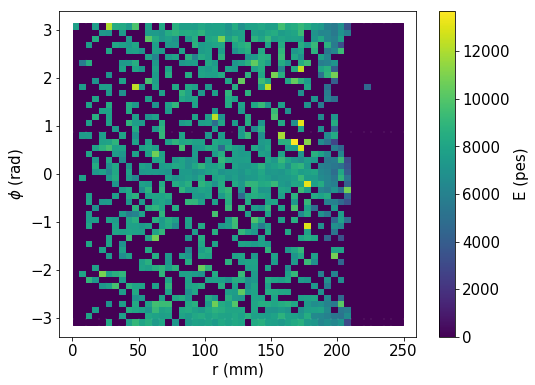

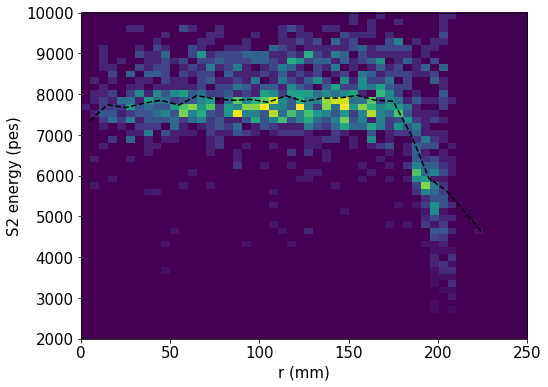

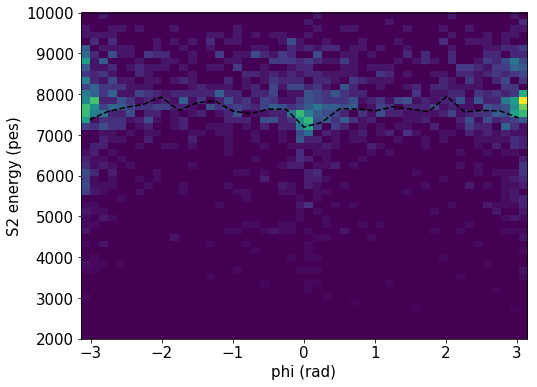

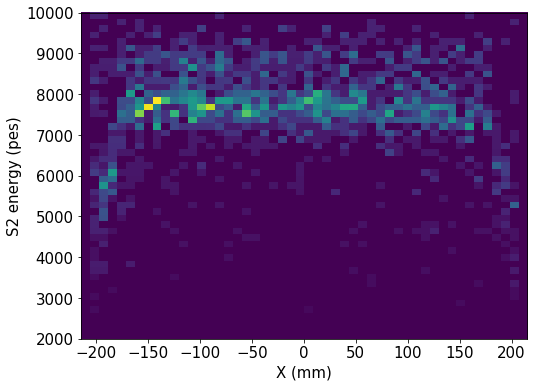

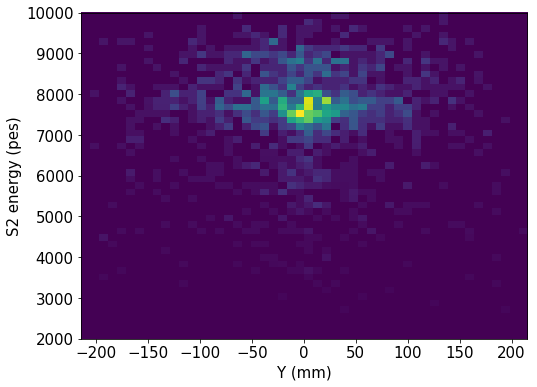

In [25]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 250
prange = - pi,  pi
Erange =  2e3, 10e3

nbin = 50

data_ = filt_XR_3740[(filt_XR_3740.Z<300)&(filt_XR_3740.R<300)][:]
data_ =  data_[data_.S2e * zcorr_3740(data_.Z)<12e3]
Ez  = data_.S2e * zcorr_3740(data_.Z)* xycorr(data_.X.values, data_.Y.values)


pf, _, cb = profile_and_scatter(data_.X, data_.Y, Ez, (25, 25), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
#save("E vs XY XY corr")

_, _, cb = profile_and_scatter(data_.R, data_.Phi, Ez, (nbin, nbin), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
#save("EvsRPhi")

hist2d(data_.R, Ez, (nbin, nbin), range=(rrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data_.R, Ez, 25, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
#save("E vs R XY coor")

hist2d(data_.Phi, Ez, (nbin, nbin), range=(prange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data_.Phi, Ez, 25, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
#save("E vs Phi XY corr")

hist2d(data_.X, Ez, (nbin, nbin), range=(xrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data_.Phi, Ez, 25, xrange=xrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("X (mm)", "S2 energy (pes)")
#save("E vs X XY corr")

hist2d(data_.Y, Ez, (nbin, nbin), range=(yrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data_.Phi, Ez, 25, xrange=xrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("Y (mm)", "S2 energy (pes)")
#save("E vs Y XY corr")

/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:123: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


[  6.20940280e+04   7.73580270e+03   2.84242112e+02   1.97049463e+04
   8.85092200e+03   3.58080841e+02   1.73290048e+00]
res 0.0865314434438 0.00955968619443


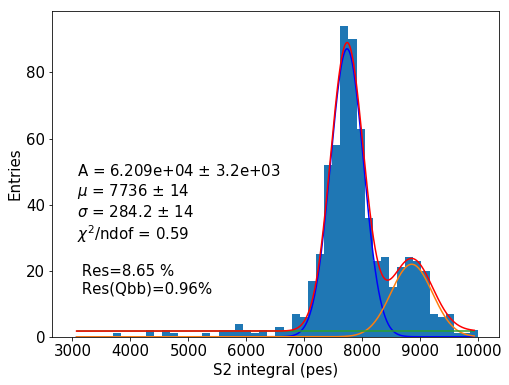

In [33]:
data_ = filt_XR_3740[(filt_XR_3740.R<180)&(filt_XR_3740.Z<150)]
E = data_.S2e * zcorr_3740(data_.Z) * xycorr(data_.X.values, data_.Y.values)

entries, xbins, _ = hist(E, 50, range=(3.0e3, 10e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 4000, 9000)


f = fitf.fit(two_gauss, xbins[selbins], entries[selbins],( 9e4, 6500, 500, 9e4, 8050, 520, 10),
                                                 bounds=([ 1e4, 6000, 100, 1e3, 8000, 100, 0],
                                                         [ 10e6, 9000, 1000,10e5, 10000, 600, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)

xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]))
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
labels("S2 integral (pes)", "Entries")
#save(" RX XYZ Corr (Z<150 R<150)")
mu1 = 7736

[  1.29082597e+05  -6.60332770e-03] [  4.37245160e+02   1.04923252e-02]


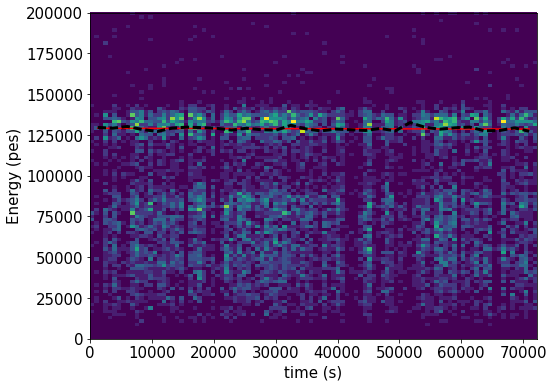

In [43]:
data_ = filt_noXR_3740[(filt_noXR_3740.R<180)]#&(filt_noXR_3740.Z<150)]
E = data_.S2e * zcorr_3740(data_.Z) * xycorr(data_.X.values, data_.Y.values)
time = data_.time.values
time -= np.min(time)
hist2d(time, E,[100,100],[[min(time),max(time)],[0,2e5]]);
x, y, _ = fitf.profileX(time,E, 30, xrange = (min(time),max(time)), yrange=[1e5,2e5])

f = fitf.fit(fitf.polynom, x, y, (6000,-200))
plt.plot(x, f.fn(x), fitOpt)
print(f.values,f.errors)

plt.plot(x, y, profOpt, linewidth=3)
labels("time (s)", "Energy (pes)")
#save("Energy vs time")

In [ ]:
xs = np.loadtxt('xycorr_xs_PP_3614.dat')
ys = np.loadtxt('xycorr_ys_PP_3614.dat')
es = np.loadtxt('xycorr_es_PP_3614.dat')

xycorr_PP = get_xycorr(xs, ys,es)

In [ ]:
data_ = data_3740[(data_3740.R<180)&(data_3740.nS2 ==1)]
E = data_.S2e# * zcorr_3740(data_.Z) * xycorr(data_.X.values, data_.Y.values)

entries, xbins, _ = hist(E, 50, range=(1.0e5, 1.6e5))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.15e5, 1.3e5)


f = fitf.fit(one_gauss, xbins[selbins], entries[selbins],( 9e4 , 1.3e5, 5000, 10),
                                                 bounds=([ 8e4 , 1.0e5, 1000,  0],
                                                         [ 10e6, 1.6e5, 10000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)


xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
mu_3740 = xbins[np.argmax(entries)]

In [ ]:
data_ = data_3740[(data_3740.R<180)&(data_3740.nS2 ==1)]
E = data_.S2e * zcorr_3740(data_.Z) * xycorr(data_.X.values, data_.Y.values)

entries, xbins, _ = hist(E, 50, range=(1.0e5, 1.6e5))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.15e5, 1.3e5)


f = fitf.fit(one_gauss, xbins[selbins], entries[selbins],( 9e4 , 1.3e5, 5000, 10),
                                                 bounds=([ 8e4 , 1.0e5, 1000,  0],
                                                         [ 10e6, 1.6e5, 10000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)


xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
mu_3740 = xbins[np.argmax(entries)]

In [ ]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 250
prange = - pi,  pi
Erange =  1e5, 1.4e5
nbin = 50

data_ = data_3740[(data_3740.R<180)&(data_3740.nS2 ==1)]

Ez  = data_.S2e * zcorr_3740(data_.Z) * xycorr(data_.X.values, data_.Y.values)


pf, _, cb = profile_and_scatter(data_.X, data_.Y, Ez, (nbin, nbin), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
#save("EvsXY")

_, _, cb = profile_and_scatter(data_.R, data_.Phi, Ez, (nbin, nbin), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
#save("EvsRPhi")

hist2d(data_.R, Ez, (nbin, nbin), range=(rrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data_.R, Ez, nbin, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
#save("EvsR")

hist2d(data_.Phi, Ez, (nbin, nbin), range=(prange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data_.Phi, Ez, nbin, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
#save("EvsPhi")

hist2d(data_.X, Ez, (nbin, nbin), range=(xrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data_.X, Ez, nbin, xrange=xrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("X (mm)", "S2 energy (pes)")

hist2d(data_.Y, Ez, (nbin, nbin), range=([-50,50], Erange), weights=Ez)
x, y, _ = fitf.profileX(data_.Y, Ez, nbin, xrange=yrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("Y (mm)", "S2 energy (pes)")

time = data_.time
time -= np.min(time)

hist2d(time, Ez, (nbin, nbin), range=([-50,50], Erange), weights=Ez)
x, y, _ = fitf.profileX(time, Ez, nbin, xrange=[0,10000], yrange=Erange)
plt.plot(x, y, profOpt)
labels("t (s)", "S2 energy (pes)")


np.savetxt('xycorr_xs_PP_3740.dat',np.array(pf[0]))
np.savetxt('xycorr_ys_PP_3740.dat',np.array(pf[1]))
np.savetxt('xycorr_es_PP_3740.dat',np.array(pf[2]))

xycorr_PP_3740 = get_xycorr(pf[0], pf[1],pf[2])

In [ ]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 250
prange = - pi,  pi
Erange =  1e5, 1.4e5
nbin = 25

data_ = data_3740[(data_3740.R<180)&(data_3740.nS2 ==1)]

Ez  = data_.S2e * zcorr_3740(data_.Z)* xycorr(data_.X.values, data_.Y.values)*xycorr_PP_3740(data_.X.values, data_.Y.values)


pf, _, cb = profile_and_scatter(data_.X, data_.Y, Ez, (nbin, nbin), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
#save("EvsXY") 

_, _, cb = profile_and_scatter(data_.R, data_.Phi, Ez, (nbin, nbin), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
#save("EvsRPhi")

hist2d(data_.R, Ez, (nbin, nbin), range=(rrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data_.R, Ez, nbin, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
#save("EvsR")

hist2d(data_.Phi, Ez, (nbin, nbin), range=(prange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data_.Phi, Ez, nbin, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
#save("EvsPhi")

hist2d(data_.X, Ez, (nbin, nbin), range=(xrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data_.Phi, Ez, nbin, xrange=xrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("X (mm)", "S2 energy (pes)")

hist2d(data_.Y, Ez, (nbin, nbin), range=(yrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data_.Phi, Ez, nbin, xrange=xrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("Y (mm)", "S2 energy (pes)")

In [ ]:
data_ = data_3740[(data_3740.R<180)&(data_3740.nS2 ==1)]

Ez  = data_.S2e * zcorr_3740(data_.Z)* xycorr(data_.X.values, data_.Y.values)*xycorr_PP_3740(data_.X.values, data_.Y.values)

entries, xbins, _ = hist(Ez, 50, range=(1.0e5, 1.6e5))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.15e5, 1.3e5)


f = fitf.fit(one_gauss, xbins[selbins], entries[selbins],( 9e4 , 1.3e5, 5000, 10),
                                                 bounds=([ 8e4 , 1.0e5, 1000,  0],
                                                         [ 10e6, 1.6e5, 10000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)


xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
mu_3740 = xbins[np.argmax(entries)]

In [ ]:
data_ = data_3740[(data_3740.Z>150)&(data_3740.nS2 ==1)]
E = data_.S2e * zcorr_3740( data_.Z)

xbin, ybin, z, axis = hist2d(data_.R, E, 100, [[0,250], [2000,2e5]])
x, y, _ = fitf.profileX(data_.R, E, 30, xrange=[0,200], yrange=[1e5,2e5])
plt.plot(x, y, profOpt)
sel  = fitf.in_range(x, 0, 180)
x, y = x[sel], y[sel]
f = fitf.fit(fitf.polynom, x, y, (6000,-200, -200))
plt.plot(x, f.fn(x), fitOpt)
print(f.values)
labels("R (mm)", "Event energy (pes)")
save("Energy_vs_R")

rfun_3740  = f.fn
rmin_3740  = np.min(x)
rcorr_3740 = lambda r: rfun_3740(rmin_3740)/rfun_3740(r)
print(rfun_3740(rmin_3740))

In [ ]:
data_ = data_3740[(data_3740.R<180)&(data_3740.nS2 ==1)]
E = data_.S2e * zcorr_3740(data_.Z) * rcorr_3740(data_.R)

entries, xbins, _ = hist(E, 50, range=(1.0e5, 1.6e5))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.20e5, 1.50e5)


f = fitf.fit(one_gauss, xbins[selbins], entries[selbins],( 9e4 , 1.3e5, 5000, 10),
                                                 bounds=([ 8e4 , 1.0e5, 1000,  0],
                                                         [ 10e6, 2.0e5, 10000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)

xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)


In [ ]:
data_ = data_3740[(data_3740.R<180)&(data_3740.nS2 ==1)&(data_3740.Z >150)]
E = data_.S2e * zcorr_3740(data_.Z) * rcorr_3740(data_.R)
xbin, ybin, z, axis = hist2d(data_.Phi, E , 100, [[-pi,pi], [1.0e5, 1.55e5]])
x, y, _ = fitf.profileX(data_.Phi, E, 25, xrange=[-pi,pi], yrange=[1.0e5, 1.55e5])
plt.plot(x, y, profOpt)
def get_phicorr(T, E):
    eref = np.max(E)
    def phicorr(t):
        dt = np.abs(t[:, np.newaxis]-T)
        return eref / E[np.apply_along_axis(np.argmin, 1, dt)]
    return phicorr
phicorr_3740 = get_phicorr(x, y) 

In [ ]:
data_ = data_3740[(data_3740.R<180)&(data_3740.nS2 ==1)]
E = data_.S2e * zcorr_3740(data_.Z) * rcorr_3740(data_.R) * phicorr_3740(data_.Phi)

entries, xbins, _ = hist(E, 50, range=(1.0e5, 1.6e5))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.20e5, 2.e5)


f = fitf.fit(one_gauss, xbins[selbins], entries[selbins],( 9e4 , 1.3e5, 5000, 10),
                                                 bounds=([ 8e4 , 1.0e5, 1000,  0],
                                                         [ 10e6, 1.6e5, 10000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)


xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
mu_3740 = xbins[np.argmax(entries)]

## 3752

In [44]:
data_3752 = data_read_3752
filt_XR_3752, filt_noXR_3752 = Filter(data_3752)

Inicial:  16682 16682
nS2 > 1:  8791
S2 XR Energy:  2437
Nsimp > 0:  2437
no XR:  13980


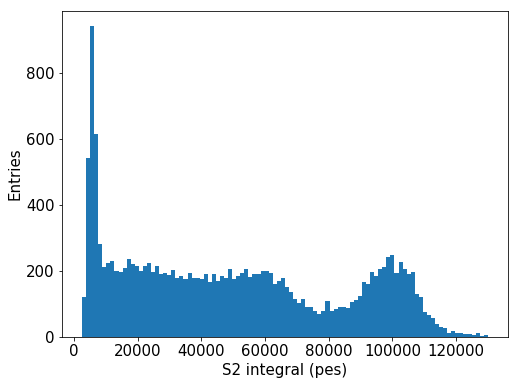

In [45]:
hist(data_3752.S2e,100,[2.5e3,1.3e5]);
labels("S2 integral (pes)", "Entries")
#save("3752 Raw Energy")

### XR Z correction

FitFunction(fn=<function fit.<locals>.<lambda> at 0x7f59d31237b8>, values=array([ 8240.50776727,  -492.75087278]), errors=array([ 321.90783456,   54.34992503]), chi2=3.2527918623104641)
6186.72552551


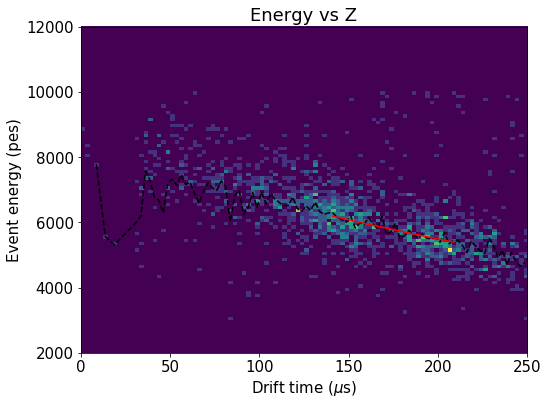

In [93]:
rcut = 180.

data_ = filt_XR_3752[filt_XR_3752.R<rcut]

xbin, ybin, z, axis = hist2d(data_.Z, data_.S2e, 100, [[0.00,250], [2000,12000]])
x, y, _ = fitf.profileX(data_.Z, data_.S2e, 100, xrange=[0,250], yrange=[2000,8000])
plt.plot(x, y, profOpt)
sel  = fitf.in_range(x, 140, 210)
x, y = x[sel], y[sel]
f = fitf.fit(fitf.expo, x, y, (1e5, -250))
plt.plot(x, f.fn(x), fitOpt)
print(f)
labels("Drift time ($\mu$s)", "Event energy (pes)")
save("Energy vs Z")

zfun_3752  = f.fn
zmin_3752  = np.min(x)
zcorr_3752 = lambda z: zfun_3752(zmin_3752)/zfun_3752(z)
print(zfun_3752(zmin_3752))

/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:123: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


[  8.20197712e+04   6.36012289e+03   3.74295467e+02   1.37016989e+04
   7.50000000e+03   2.99720520e+02   5.16130102e-01]
res 0.138592577613 0.0153112151853


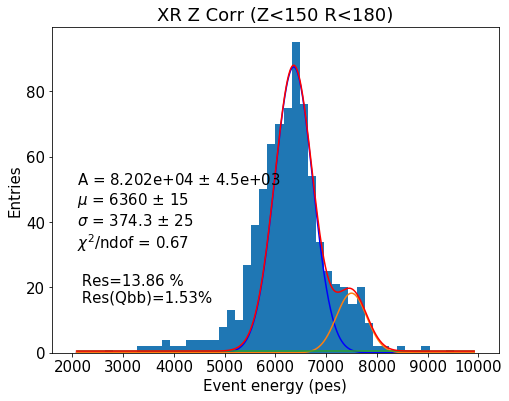

In [94]:
data_ = filt_XR_3752[(filt_XR_3752.R<180)&(filt_XR_3752.Z<150)]
E = data_.S2e * zcorr_3752(data_.Z)

entries, xbins, _ = hist(E, 50, range=(2e3, 10e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 6000, 12000)


f = fitf.fit(two_gauss, xbins[selbins], entries[selbins],( 9e4, 7000, 500, 9e4, 9050, 600, 10),
                                                 bounds=([ 1e4, 6000, 100, 0.1e4, 7500, 100, 0],
                                                         [ 10e6, 9000, 1000,10e5, 100000, 2e4, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)

xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]))
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
labels("Event energy (pes)", "Entries")
#save("XR Z Corr (Z<150 R<180)")

### XR xy corrections

/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:123: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


[  7.19472388e+04   6.24007564e+03   3.02247125e+02   2.84712381e+04
   7.13814344e+03   4.15585291e+02   5.75837368e-01]
res 0.114067844861 0.0126018099126


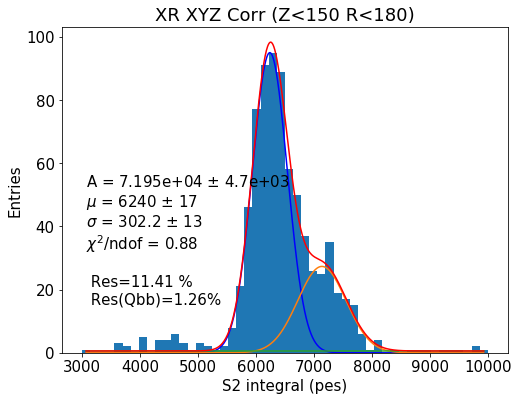

In [115]:
data_ = filt_XR_3752[(filt_XR_3752.R<180)&(filt_XR_3752.Z<150)]
E = data_.S2e * zcorr_3752(data_.Z) * xycorr(data_.X.values, data_.Y.values)

entries, xbins, _ = hist(E, 50, range=(3e3, 10e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 5000, 12000)


f = fitf.fit(two_gauss, xbins[selbins], entries[selbins],( 9e4, 6500, 100, 9e4, 9050, 100, 10),
                                                 bounds=([ 0.1e4, 6000, 100, 0.1e3, 7000, 100, 0],
                                                         [ 10e6, 9000, 1000,10e5, 100000, 2e4, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)

xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]))
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
labels("S2 integral (pes)", "Entries")
save("XR XYZ Corr (Z<150 R<180)")
mu2 = 6240

[  1.08651760e+05  -1.00180963e-01] [  4.66373862e+02   1.02275349e-02]


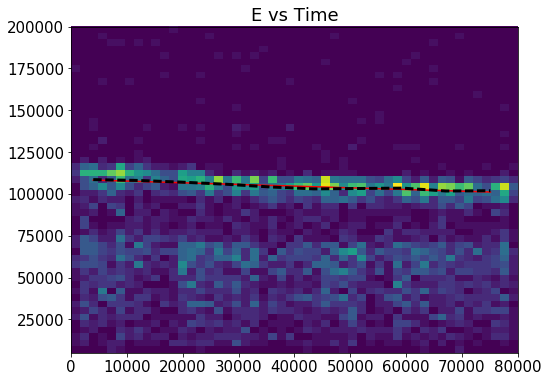

In [97]:
data_ = filt_noXR_3752[(filt_noXR_3752.R<100)]#&(filt_XR_3752.Z<150)]
Et = data_.S2e * zcorr_3752(data_.Z) * xycorr(data_.X.values, data_.Y.values)

time = data_.time
time = time-np.min(time)
hist2d(time,Et,[50,50], range=[[0,8e4],[5000,2e5]]);
x, y, _ = fitf.profileX(time,Et, 10, yrange=[0.8e5,2e5])

f = fitf.fit(fitf.polynom, x, y, (6000,-200))
plt.plot(x, f.fn(x), fitOpt)
print(f.values, f.errors)

plt.plot(x, y, profOpt, linewidth=3)

tfun_3752  = f.fn
tmin_3752  = np.min(x)
tcorr_3752 = lambda t: tfun_3752(tmin_3752)/tfun_3752(t)

save("E vs Time")


/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:123: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


[  4.08083661e+04   6.17132158e+03   3.48765197e+02   6.57382358e+03
   7.20639419e+03   2.03226830e+02   8.38625590e-01]
res 0.13309013765 0.014703325183


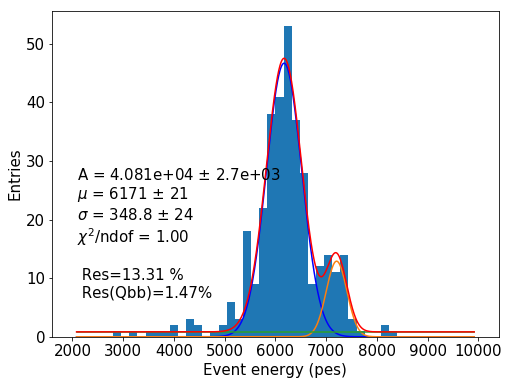

In [98]:
data_ = filt_XR_3752[(filt_XR_3752.R<100)&(filt_XR_3752.Z<150)]
time = data_.time
time = time-np.min(time)
E = data_.S2e * zcorr_3752(data_.Z)*zcorr_3752(data_.Z) * xycorr(data_.X.values, data_.Y.values) * tcorr_3752(time)


entries, xbins, _ = hist(E, 50, range=(2e3, 10e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins,5000, 12000)


f = fitf.fit(two_gauss, xbins[selbins], entries[selbins],( 9e4, 7000, 500, 9e4, 7050, 500, 10),
                                                 bounds=([ 1e4, 6000, 100, 0.1e4, 6250, 100, 0],
                                                         [ 10e6, 9000, 1000,10e5, 100000,500, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)

xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]))
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
labels("Event energy (pes)", "Entries")
#save("XR XRZt Corr (Z<150 R<100)")

In [ ]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 250
prange = - pi,  pi
Erange =  2e3, 10e3

data_ = filt_XR_3752[(filt_XR_3752.Z<300)&(filt_XR_3752.R<180)][:]
data_ =  data_[data_.S2e * zcorr_3752(data_.Z)<12e3]
Ez  = data_.S2e * zcorr_3752(data_.Z)* xycorr(data_.X.values, data_.Y.values)
print(len(Ez))

pf, _, cb = profile_and_scatter(data_.X, data_.Y, Ez, (nbin, nbin), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
#save("EvsXY")

_, _, cb = profile_and_scatter(data_.R, data_.Phi, Ez, (nbin, nbin), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
#save("EvsRPhi")

hist2d(data_.R, Ez, (nbin, nbin), range=(rrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data_.R, Ez, nbin, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
#save("EvsR")

hist2d(data_.Phi, Ez, (nbin, nbin), range=(prange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data_.Phi, Ez, nbin, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
#save("EvsPhi")

hist2d(data_.X, Ez, (nbin, nbin), range=(xrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data_.Phi, Ez, nbin, xrange=xrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("X (mm)", "S2 energy (pes)")

hist2d(data_.Y, Ez, (nbin, nbin), range=(yrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data_.Phi, Ez, nbin, xrange=xrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("Y (mm)", "S2 energy (pes)")

In [ ]:
data_ = filt_XR_3752[(filt_XR_3752.R<180)&(filt_XR_3752.Z<150)]
E = data_.S2e * zcorr_3752(data_.Z) * xycorr(data_.X.values, data_.Y.values)
print(len(E))
entries, xbins, _ = hist(E, 50, range=(3.0e3, 12e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 4000, 9000)


f = fitf.fit(two_gauss, xbins[selbins], entries[selbins],( 9e4, 6500, 500, 9e4, 8050, 520, 10),
                                                 bounds=([ 1e4, 6000, 100, 1e4, 7000, 100, 0],
                                                         [ 10e6, 9000, 1000,10e5, 10000, 600, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)

xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]))
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)

In [ ]:
data_ = data_3752[(data_3752.Z>150)&(data_3752.nS2 ==1)]
E = data_.S2e * zcorr_3752( data_.Z)

xbin, ybin, z, axis = hist2d(data_.R, E, 100, [[0,250], [2000,2e5]])
x, y, _ = fitf.profileX(data_.R, E, 30, xrange=[0,200], yrange=[0.8e5,2e5])
plt.plot(x, y, profOpt)
sel  = fitf.in_range(x, 0, 180)
x, y = x[sel], y[sel]
f = fitf.fit(fitf.polynom, x, y, (6000,-200, -200))
plt.plot(x, f.fn(x), fitOpt)
print(f.values)
labels("R (mm)", "Event energy (pes)")
save("Energy_vs_R")

rfun_3752  = f.fn
rmin_3752  = np.min(x)
rcorr_3752 = lambda r: rfun_3752(rmin_3752)/rfun_3752(r)
print(rfun_3752(rmin_3752))

In [ ]:
data_ = data_3752[(data_3752.R<180)&(data_3752.nS2 ==1)]
E = data_.S2e * zcorr_3752(data_.Z) * rcorr_3752(data_.R)

entries, xbins, _ = hist(E, 50, range=(0.5e5, 1.6e5))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.05e5, 1.6e5)


f = fitf.fit(one_gauss, xbins[selbins], entries[selbins],( 9e4 , 1.2e5, 5000, 10),
                                                 bounds=([ 8e4 , 1.0e5, 1000,  0],
                                                         [ 10e6, 2.0e5, 10000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)

xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))



In [ ]:
data_ = data_3752[(data_3752.R<180)&(data_3752.nS2 ==1)&(data_3752.Z >150)]
E = data_.S2e * zcorr_3752(data_.Z) * rcorr_3752(data_.R)
xbin, ybin, z, axis = hist2d(data_.Phi, E , 100, [[-pi,pi], [1.0e5, 1.55e5]])
x, y, _ = fitf.profileX(data_.Phi, E, 25, xrange=[-pi,pi], yrange=[1.0e5, 1.55e5])
plt.plot(x, y, profOpt)
def get_phicorr(T, E):
    eref = np.max(E)
    def phicorr(t):
        dt = np.abs(t[:, np.newaxis]-T)
        return eref / E[np.apply_along_axis(np.argmin, 1, dt)]
    return phicorr
phicorr_3752 = get_phicorr(x, y) 

In [ ]:
data_ = data_3752[(data_3752.R<180)&(data_3752.nS2 ==1)]
E = data_.S2e * zcorr_3752(data_.Z) * rcorr_3752(data_.R) * phicorr_3752(data_.Phi)

entries, xbins, _ = hist(E, 50, range=(0.5e5, 1.6e5))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.0e5, 1.5e5)


f = fitf.fit(one_gauss, xbins[selbins], entries[selbins],( 9e4 , 1.1e5, 5000, 10),
                                                 bounds=([ 8e4 , 1.0e5, 1000,  0],
                                                         [ 10e6, 1.2e5, 10000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)


xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
mu_3752 = xbins[np.argmax(entries)]

### 3755

In [49]:
data_3755 = data_read_3755
filt_XR_3755, filt_noXR_3755 = Filter(data_3755)

Inicial:  14870 14870
nS2 > 1:  7868
S2 XR Energy:  2185
Nsimp > 0:  2185
no XR:  12454


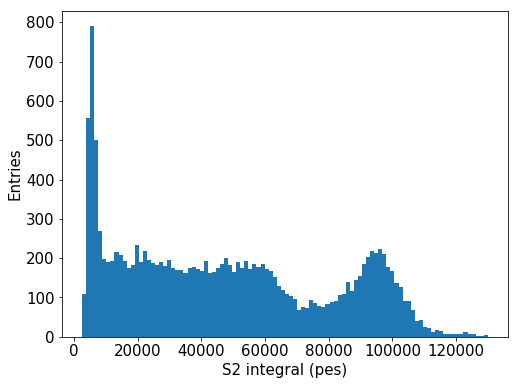

In [50]:
hist(data_3755.S2e,100,[2.5e3,1.3e5]);
labels("S2 integral (pes)", "Entries")
#save("3755 Raw Energy")

### XR z correction

FitFunction(fn=<function fit.<locals>.<lambda> at 0x7f59d3105a60>, values=array([ 8014.2695697 ,  -441.73696224]), errors=array([ 203.3596322 ,   29.34982712]), chi2=4.1421896514300043)
6090.55392468


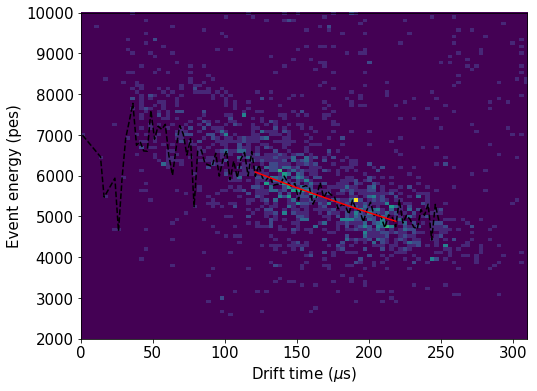

In [101]:
rcut = 200.

data_ = filt_XR_3755[filt_XR_3755.R<rcut]

xbin, ybin, z, axis = hist2d(data_.Z, data_.S2e, 100, [[0.00,310], [2000,10000]])
x, y, _ = fitf.profileX(data_.Z, data_.S2e, 100, xrange=[0,250], yrange=[2000,8000])
plt.plot(x, y, profOpt)
sel  = fitf.in_range(x, 120, 220)
x, y = x[sel], y[sel]
f = fitf.fit(fitf.expo, x, y, (1e5, -250))
plt.plot(x, f.fn(x), fitOpt)
print(f)
labels("Drift time ($\mu$s)", "Event energy (pes)")
#save("Energy vs Z")

zfun_3755  = f.fn
zmin_3755  = np.min(x)
zcorr_3755 = lambda z: zfun_3755(zmin_3755)/zfun_3755(z)
print(zfun_3755(zmin_3755))

[  2.01426046e+05   6.19825414e+03   5.89857113e+02   8.75754226e+03
   7.44186303e+03   1.71755903e+02   4.56368193e+00]
res 0.224113672707 0.0247592816865


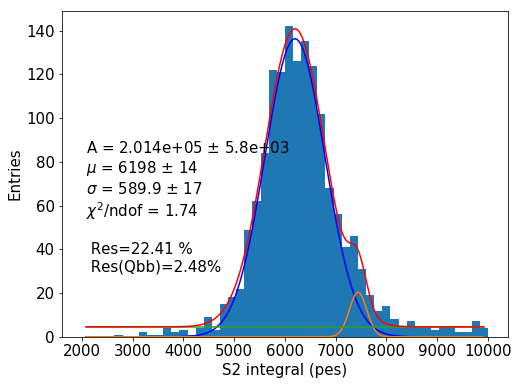

In [102]:
data_ = filt_XR_3755[filt_XR_3755.R<180]
E = data_.S2e * zcorr_3755(data_.Z)

entries, xbins, _ = hist(E, 50, range=(2e3, 10e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 4000, 12000)


f = fitf.fit(two_gauss, xbins[selbins], entries[selbins],( 9e4, 7000, 500, 9e4, 9050, 600, 10),
                                                 bounds=([ 8e4, 6000, 100, 0.1e4, 7000, 100, 0],
                                                         [ 10e6, 9000, 1000,10e5, 100000, 2e4, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)

xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]))
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)

labels("S2 integral (pes)", "Entries")
#save(" RX Z Corr (Z<150 R<180)")

/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:123: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


[  8.87360002e+04   6.37213357e+03   3.48892476e+02   1.82601170e+04
   7.35438842e+03   2.99774660e+02   1.60454168e+00]
res 0.128942962509 0.0142451600194


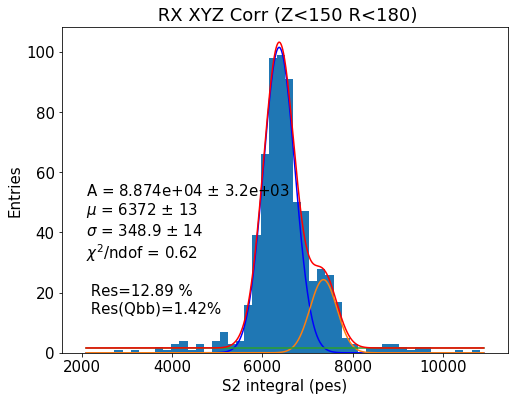

In [117]:
data_ = filt_XR_3755[(filt_XR_3755.R<180)&(filt_XR_3755.Z<150)]
E = data_.S2e * zcorr_3755(data_.Z) *xycorr(data_.X.values, data_.Y.values)

entries, xbins, _ = hist(E, 50, range=(2e3, 11e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 4000, 12000)


f = fitf.fit(two_gauss, xbins[selbins], entries[selbins],( 9e4, 7000, 500, 9e4, 7050, 200, 10),
                                                 bounds=([ 0.1e4, 5000, 100, 0.1e4, 6100, 100, 0],
                                                         [ 10e6, 9000, 1000,10e5, 100000, 350, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)

xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]))
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
labels("S2 integral (pes)", "Entries")
save(" RX XYZ Corr (Z<150 R<180)")
mu3 = 6372

/home/brais/miniconda/envs/IC3.5/lib/python3.5/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:128: RuntimeWarning: divide by zero encountered in double_scalars
  chi2 / (len(x) - len(vals)))


[  1.86606028e+05  -4.34545426e+01   8.59573376e-03  -8.51211024e-07
   4.80749145e-11  -1.64231385e-15   3.45282466e-20  -4.36718709e-25
   3.04765359e-30  -9.01510055e-36]


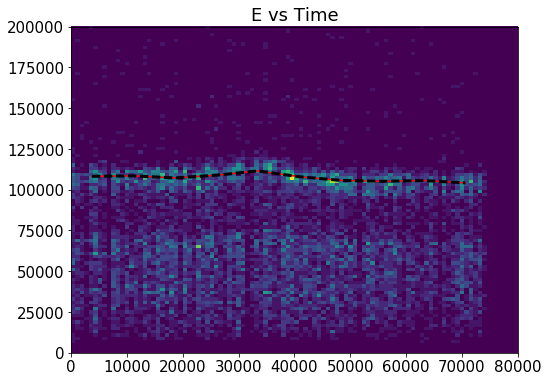

In [111]:
data_ = filt_noXR_3755[(filt_noXR_3755.R<180)]#&(filt_XR_3755.Z<150)]
Et = data_.S2e * zcorr_3755(data_.Z) * xycorr(data_.X.values, data_.Y.values)

time = data_.time
time = time-np.min(time)
hist2d(time,Et,[100,100], range=[[0,8e4],[0,2e5]]);
x, y, _ = fitf.profileX(time,Et, 10, yrange=[0.9e5,2e5])

f = fitf.fit(fitf.polynom, x, y, (6000,-200, 500,100,-200, 500,100,-200, 500,100))
plt.plot(x, f.fn(x), fitOpt)
print(f.values)

plt.plot(x, y, profOpt, linewidth=3)

tfun_3755  = f.fn
tmin_3755  = np.min(x)
tcorr_3755 = lambda t: tfun_3755(tmin_3755)/tfun_3755(t)

save("E vs Time")

/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:123: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


[  6.57553555e+04   6.40553457e+03   3.29744203e+02   1.29009789e+04
   7.36186922e+03   2.50000000e+02   3.04390376e+00]
res 0.121230724533 0.0133931393899


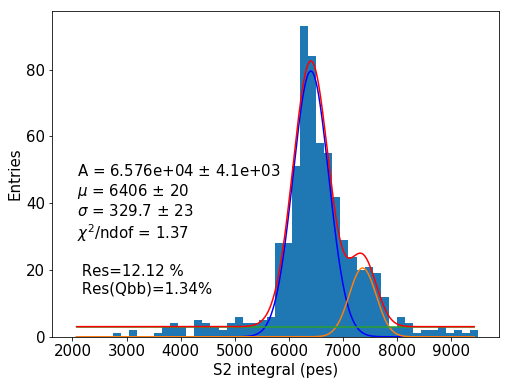

In [113]:
data_ = filt_XR_3755[(filt_XR_3755.R<180)&(filt_XR_3755.Z<150)]
time = data_.time
time = time-np.min(time)
E = data_.S2e * zcorr_3755(data_.Z) *xycorr(data_.X.values, data_.Y.values) * tcorr_3755(time)

entries, xbins, _ = hist(E, 50, range=(2e3, 9.5e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 4000, 12000)


f = fitf.fit(two_gauss, xbins[selbins], entries[selbins],( 9e4, 7000, 500, 9e4, 7050, 200, 10),
                                                 bounds=([ 0.1e4, 6000, 100, 0.1e4, 7000, 100, 0],
                                                         [ 10e6, 9000, 1000,10e5, 100000, 250, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)

xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]))
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
labels("S2 integral (pes)", "Entries")
#save(" RX XYZt Corr (Z<150 R<100)")

In [ ]:
data_ = data_3755[(data_3755.Z>150)&(data_3755.nS2 ==1)]
E = data_.S2e * zcorr_3755( data_.Z)

xbin, ybin, z, axis = hist2d(data_.R, E, 100, [[0,250], [2000,2e5]])
x, y, _ = fitf.profileX(data_.R, E, 30, xrange=[0,200], yrange=[0.8e5,2e5])
plt.plot(x, y, profOpt)
sel  = fitf.in_range(x, 0, 180)
x, y = x[sel], y[sel]
f = fitf.fit(fitf.polynom, x, y, (6000,-200, -200))
plt.plot(x, f.fn(x), fitOpt)
print(f.values)
labels("R (mm)", "Event energy (pes)")
save("Energy_vs_R")

rfun_3755  = f.fn
rmin_3755  = np.min(x)
rcorr_3755 = lambda r: rfun_3755(rmin_3755)/rfun_3755(r)
print(rfun_3755(rmin_3755))

In [ ]:
data_ = data_3755[(data_3755.R<180)&(data_3755.nS2 ==1)]
E = data_.S2e * zcorr_3755(data_.Z) * rcorr_3755(data_.R)

entries, xbins, _ = hist(E, 50, range=(0.5e5, 1.55e5))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.1e5, 1.30e5)


f = fitf.fit(one_gauss, xbins[selbins], entries[selbins],( 9e4 , 1.1e5, 5000, 10),
                                                 bounds=([ 8e4 , 1.0e5, 1000,  0],
                                                         [ 10e6, 1.4e5, 10000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)

xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)

In [ ]:
data_ = data_3755[(data_3755.R<180)&(data_3755.nS2 ==1)&(data_3755.Z >150)]
E = data_.S2e * zcorr_3755(data_.Z) * rcorr_3755(data_.R)
xbin, ybin, z, axis = hist2d(data_.Phi, E , 100, [[-pi,pi], [1.0e5, 1.55e5]])
x, y, _ = fitf.profileX(data_.Phi, E, 25, xrange=[-pi,pi], yrange=[1.0e5, 1.55e5])
plt.plot(x, y, profOpt)
def get_phicorr(T, E):
    eref = np.max(E)
    def phicorr(t):
        dt = np.abs(t[:, np.newaxis]-T)
        return eref / E[np.apply_along_axis(np.argmin, 1, dt)]
    return phicorr
phicorr_3755 = get_phicorr(x, y)

In [ ]:
data_ = v
E = data_.S2e * zcorr_3755(data_.Z) * rcorr_3755(data_.R) * phicorr_3755(data_.Phi)

entries, xbins, _ = hist(E, 50, range=(1.0e5, 1.6e5))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.15e5, 1.5e5)


f = fitf.fit(one_gauss, xbins[selbins], entries[selbins],( 9e4 , 1.3e5, 5000, 10),
                                                 bounds=([ 8e4 , 1.0e5, 1000,  0],
                                                         [ 10e6, 1.6e5, 10000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)


xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
mu_3755 = f.values[1]

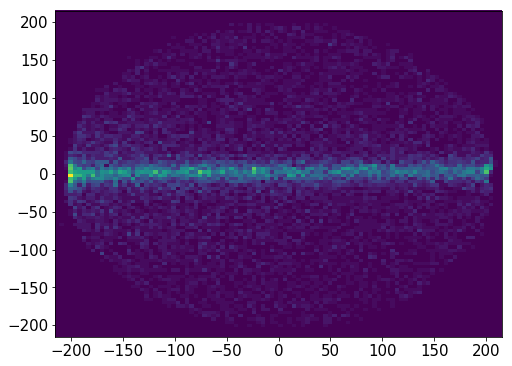

In [149]:
data_ = data_3755
hist2d(data_.X,data_.Y,[100,100],[[-215,215],[-215,215]]);

### Run addition

In [118]:
mean = 6500

data_3740_ = deepcopy(data_3740)
data_3740_.S2e = data_3740_.S2e * zcorr_3740(data_3740_.Z) * xycorr(data_3740_.X.values, data_3740_.Y.values) *mean/mu1

data_3752_ =  deepcopy(data_3752)
data_3752_.S2e = data_3752_.S2e * zcorr_3752(data_3752_.Z) * xycorr(data_3752_.X.values, data_3752_.Y.values) *mean/mu2
data_3755_ =  deepcopy(data_3755)
data_3755_.S2e = data_3755_.S2e * zcorr_3755(data_3755_.Z) * xycorr(data_3755_.X.values, data_3755_.Y.values) *mean/mu3




In [119]:
data_ad = pd.concat([data_3740_, data_3752_, data_3755_])

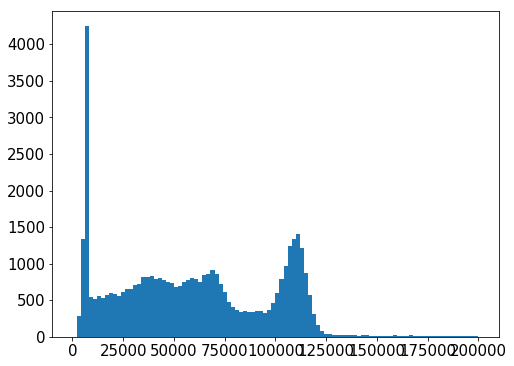

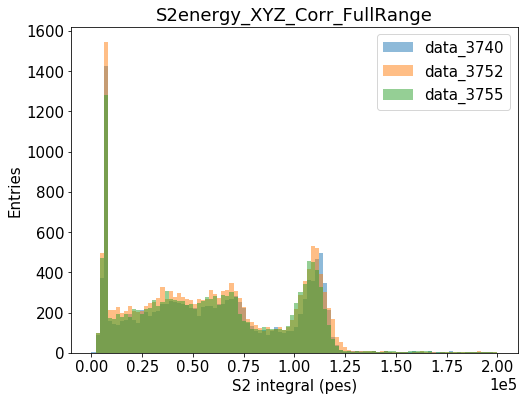

In [120]:
data_ = data_ad
hist(data_.S2e,100,[0,2e5]);

data_usefull = [data_3740_, data_3752_, data_3755_]
data_usefull_names = ["data_3740", "data_3752", "data_3755"]
plt.figure()
for i in data_usefull: 
    plt.hist(i.S2e, 100, [0, 2e5], alpha=0.5)
plt.legend(data_usefull_names)

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

labels("S2 integral (pes)", "Entries")
save("S2energy_XYZ_Corr_FullRange")
plt.show()

[  1.00000000e+07   1.10915910e+05   3.99955986e+03   5.51386118e+01]
res 0.0849198593941 0.0387194141212


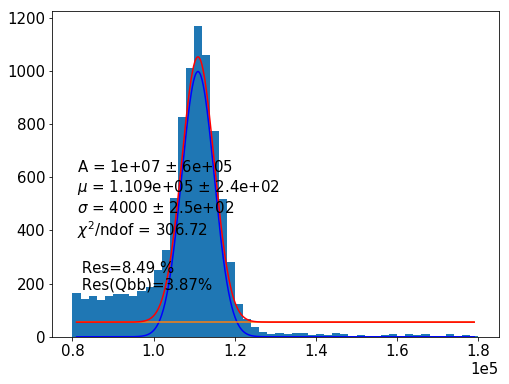

In [133]:
data_ = data_ad[(data_ad.R<180)&(data_ad.nS2 ==1)]
E = data_.S2e 

entries, xbins, _ = hist(E, 50, range=(0.80e5, 1.8e5))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.0e5, 1.8e5)


f = fitf.fit(one_gauss, xbins[selbins], entries[selbins],( 9e4 , 1.3e5, 5000, 10),
                                                 bounds=([ 1e4 , 1.0e5, 1000,  0],
                                                         [ 10e6, 1.6e5, 10000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)


xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:123: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


[  7.18019079e+06   1.10609416e+05   4.19495127e+03   4.92658548e+00]
res 0.0893152735118 0.0407235137591


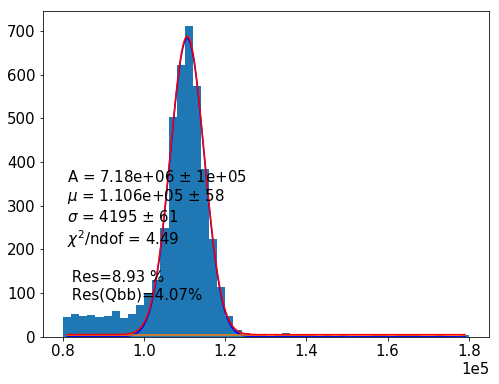

In [134]:
data_ = data_ad[(data_ad.R<100)&(data_ad.nS2 ==1)]
E = data_.S2e 

entries, xbins, _ = hist(E, 50, range=(0.80e5, 1.8e5))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.0e5, 1.8e5)


f = fitf.fit(one_gauss, xbins[selbins], entries[selbins],( 9e4 , 1.3e5, 5000, 10),
                                                 bounds=([ 1e4 , 1.0e5, 1000,  0],
                                                         [ 10e6, 1.6e5, 10000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)


xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

88168.2783607


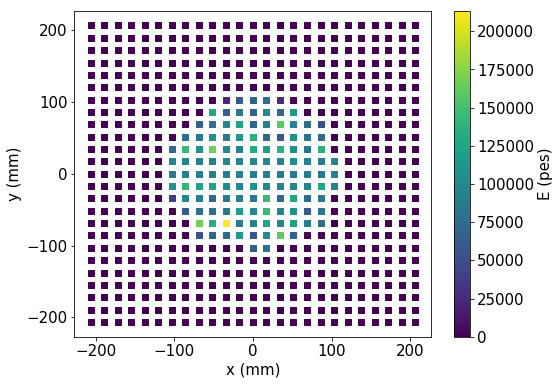

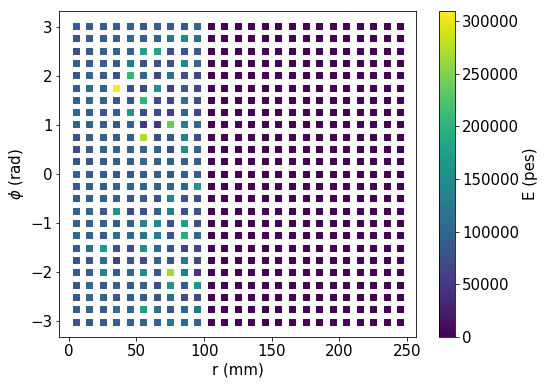

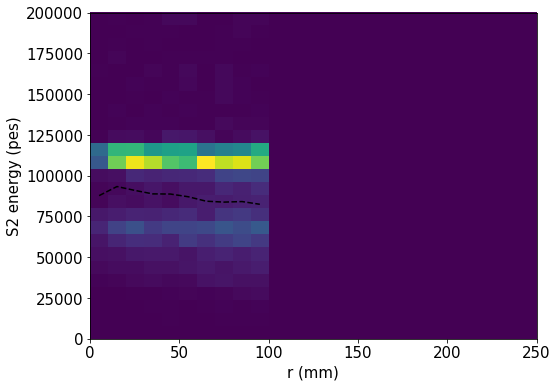

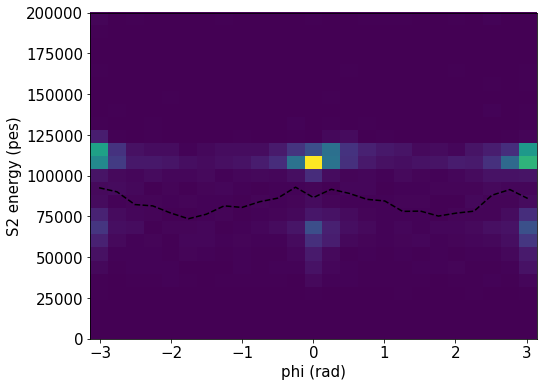

In [137]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 250
prange = - pi,  pi
Erange =  0e3, 2e5
nbin = 25

#data = filt_XR[filt_XR.Z<150][:]
data = data_ad[(data_ad.R<100)&(data_ad.nS2 ==1)]
Ez  = data.S2e


pf, _, cb = profile_and_scatter(data.X, data.Y, Ez, (nbin, nbin), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
#save("EvsXY")

_, _, cb = profile_and_scatter(data.R, data.Phi, Ez, (nbin, nbin), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
#save("EvsRPhi")

hist2d(data.R, Ez, (nbin, nbin), range=(rrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.R, Ez, nbin, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
#save("EvsR")

hist2d(data.Phi, Ez, (nbin, nbin), range=(prange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.Phi, Ez, nbin, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
#save("EvsPhi")

'''
np.savetxt('xycorr_xs_3614.dat',np.array(pf[0]))
np.savetxt('xycorr_ys_3614.dat',np.array(pf[1]))
np.savetxt('xycorr_es_3614.dat',np.array(pf[2]))
'''



def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr
xycorr_PP = get_xycorr(*pf[:-1])

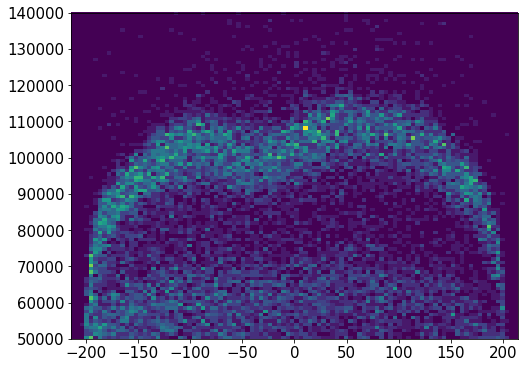

In [153]:
data = data_read_combined[data_read_combined.nS2==1]
hist2d(data.X, data.S2e,[100,100], [[-214,214],[0.5e5,1.4e5]]);

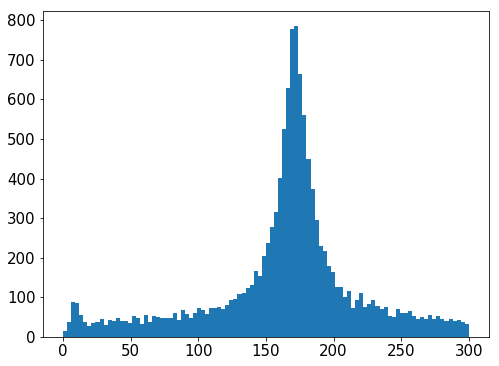

In [154]:
data = data_read_combined[data_read_combined.nS2==1]
E = data_.S2e 

hist(data_.Z,100,[0,300])
plt.show()